In [21]:
from __future__ import division #, print_function # Imports from __future__ since we're running Python 2
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
random_state = 10 # Ensure reproducible results

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
%matplotlib inline
plt.style.use('classic')
plt.rc("figure", facecolor="white")

In [3]:
random_state=0
rng = np.random.RandomState(seed=random_state)

In [4]:
path_data = os.path.join(os.getcwd(),'NY_flights.csv')
data = pd.read_csv(path_data, delimiter = ',')

In [5]:
print("There are {} entries and {} columns in the flight data"\
      .format(data.shape[0], data.shape[1]))

There are 481662 entries and 30 columns in the flight data


In [6]:
data = data.drop('Unnamed: 0', axis =1)
data = data[data['DEP_DELAY'] < 300]
data['DEP_DELAY'] = np.maximum(data['DEP_DELAY'], -30)

In [7]:
print("There are {} entries and {} columns in the flight data"\
      .format(data.shape[0], data.shape[1]))

There are 479820 entries and 29 columns in the flight data


#### Preprocessing

In [19]:
temp = upcoming_flights.groupby('ARR_DELAY_GROUP')['ARR_DELAY'].count()

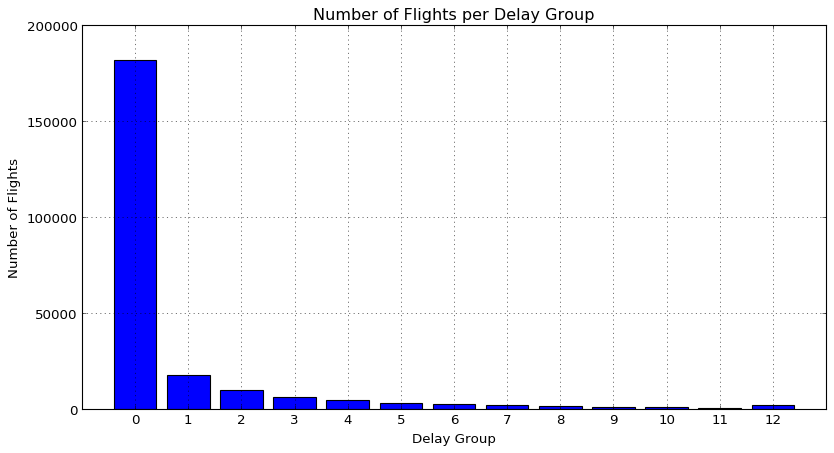

In [25]:
plt.figure(figsize=(12,6))
plt.bar(np.arange(0,13), temp,  align='center')
plt.xticks(np.arange(0,13), np.arange(0,13))
plt.title('Number of Flights per Delay Group')
plt.xlabel('Delay Group')
plt.ylabel('Number of Flights')
plt.xlim([-1,13])
plt.grid(True)
plt.show()

In [9]:
upcoming_flights = data[data['ORIGIN_STATE_ABR'] != 'NY']

In [10]:
print("There are {} entries and {} columns in the flight data"\
      .format(upcoming_flights.shape[0], upcoming_flights.shape[1]))

There are 234292 entries and 29 columns in the flight data


In [11]:
upcoming_flights.loc[upcoming_flights['ARR_DELAY_GROUP'] < 0, 'ARR_DELAY_GROUP'] = 0

C:\Users\chris\Anaconda3\envs\mlp\lib\site-packages\pandas\core\indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [12]:
nondelayed = upcoming_flights[upcoming_flights['ARR_DELAY_GROUP'] == 0]
nondelayed.shape

(181627, 29)

In [13]:
delayed = upcoming_flights[upcoming_flights['ARR_DELAY_GROUP'] > 0]
delayed.shape

(52665, 29)

In [50]:
non_delayed_short = shuffle(nondelayed, random_state = random_state, n_samples = int(len(delayed)))
non_delayed_short.shape

(48975, 29)

In [51]:
flights = shuffle(pd.concat((delayed, non_delayed_short)), random_state = random_state)
flights.shape

(97950, 29)

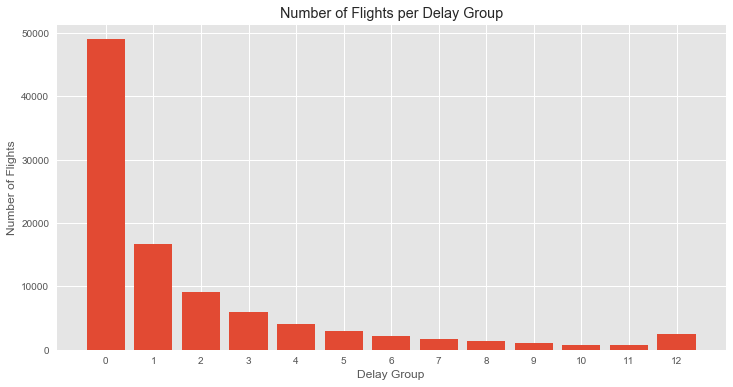

In [52]:
temp = flights.groupby('ARR_DELAY_GROUP')['ARR_DELAY'].count()
plt.figure(figsize=(12,6))
plt.bar(np.arange(0,13), temp,  align='center')
plt.xticks(np.arange(0,13), np.arange(0,13))
plt.title('Number of Flights per Delay Group')
plt.xlabel('Delay Group')
plt.ylabel('Number of Flights')

## Feature Engineering

In [53]:
from helpers.my_one_hot_encoder import MyOneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [54]:
data_frame = flights.copy(deep=True)

In [55]:
le_dict = dict() # Initialise an empty dictionary to keep all LabelEncoders
df_hol = flights.copy(deep=True) # Make a copy of the DataFrame
le = LabelEncoder().fit(data_frame['FL_DATE']) # Initialise the LabelEncoder and fit
df_hol['FL_DATE'] = le.transform(data_frame['FL_DATE']) # Transform data and save in credit_clean DataFrame
le_dict['FL_DATE'] = le # Store the LabelEncdoer in dictionary

# increase the day by one because Label Encoder starts from 0
holidays = [0, 17, 42, 105, 150, 165, 248, 283, 315, 328, 329, 360]

In [56]:
# make a binary holiday feature (if on holiday or not)
isholiday = np.zeros(df_hol.shape[0])
i = 0
for day in df_hol['FL_DATE']:
    if (day in holidays):
        isholiday[i] = 1
    i += 1

In [57]:
df_hol['IS_HOLIDAY'] = isholiday

In [58]:
# make aa feature for the days from the next closest holiday
DAYS_TO_NEXT_HOLIDAY = np.zeros(df_hol.shape[0])
i = 0
for day in df_hol['FL_DATE']:
    for holiday in holidays:
        if holiday >= day:
            DAYS_TO_NEXT_HOLIDAY[i] = holiday - day
            break
    i += 1

In [59]:
df_hol['DAYS_TO_NEXT_HOLIDAY'] = DAYS_TO_NEXT_HOLIDAY

In [60]:
# make a feature for the days from the previous closest holiday
DAYS_FROM_LAST_HOLIDAY = np.zeros(df_hol.shape[0])
i = 0
for day in df_hol['FL_DATE']:
    for holiday in reversed(holidays):
        if holiday <= day:
            DAYS_FROM_LAST_HOLIDAY[i] = day - holiday
            break    
    i += 1

In [61]:
df_hol['DAYS_FROM_LAST_HOLIDAY'] = DAYS_FROM_LAST_HOLIDAY

In [62]:
# make a feature for the days from the closest holiday
df_hol['DAYS_FROM_NEAREST_HOLIDAY'] = df_hol[['DAYS_FROM_LAST_HOLIDAY', 'DAYS_TO_NEXT_HOLIDAY']].min(axis=1)   

In [63]:
flights_dropped = df_hol.copy(deep=True) 

In [64]:
le_dict = dict() # Initialise an empty dictionary to keep all LabelEncoders
df_hot = flights_dropped.copy(deep=True) # Make a copy of the DataFrame
# Loop over attributes by excluding the ones that are continuous and the target variable
# DEP_DELAY_GROUP
for column in df_hot.drop(['DEP_TIME', 'DEP_DEL15','DEP_DELAY', 'ARR_TIME', 'ARR_DELAY', 'ARR_DEL15', 
                           'ARR_DELAY_GROUP', 'DISTANCE', 'DAYS_TO_NEXT_HOLIDAY', 'DAYS_FROM_LAST_HOLIDAY', 
                          'DAYS_FROM_NEAREST_HOLIDAY','IS_HOLIDAY'], axis=1):  
    le = LabelEncoder().fit(flights_dropped[column]) # Initialise the LabelEncoder and fit
    df_hot[column] = le.transform(flights_dropped[column]) # Transform data and save in credit_clean DataFrame
    le_dict[column] = le # Store the LabelEncdoer in dictionary

In [65]:
columns_one_hot = ['DEP_TIME_BLK', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'ORIGIN_STATE_NM', 'UNIQUE_CARRIER', 'DEST', 'DEP_DELAY_GROUP',
                  'DISTANCE_GROUP']

In [66]:
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

In [67]:
everything = one_hot(df_hot, columns_one_hot)

In [68]:
everything.shape

(97950, 239)

In [69]:
flights.columns

Index(['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE',
       'UNIQUE_CARRIER', 'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR',
       'ORIGIN_STATE_NM', 'DEST', 'DEST_CITY_NAME', 'DEST_STATE_ABR',
       'DEST_STATE_NM', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'DEP_DEL15',
       'DEP_DELAY_GROUP', 'DEP_TIME_BLK', 'CRS_ARR_TIME', 'ARR_TIME',
       'ARR_DELAY', 'ARR_DEL15', 'ARR_DELAY_GROUP', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'DISTANCE', 'DISTANCE_GROUP'],
      dtype='object')

In [70]:
drop_cols = ['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'FL_DATE',
       'UNIQUE_CARRIER', 'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR',
       'ORIGIN_STATE_NM', 'DEST', 'DEST_CITY_NAME', 'DEST_STATE_ABR',
       'DEST_STATE_NM', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'DEP_DEL15',
       'DEP_DELAY_GROUP', 'DEP_TIME_BLK', 'CRS_ARR_TIME', 'ARR_TIME',
       'ARR_DELAY', 'ARR_DEL15', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'DISTANCE', 'DISTANCE_GROUP']

In [71]:
data_frame = everything.drop(drop_cols, axis=1)

In [34]:
data_train, data_test = train_test_split(data_frame, test_size=0.2, random_state=random_state)

In [35]:
data_train.to_csv(
    os.path.realpath(os.path.join(os.getcwd(), 'train_data_ongoing.csv')),
    index=False)

In [36]:
data_test.to_csv(
    os.path.realpath(os.path.join(os.getcwd(),'test_data_ongoing.csv')),
    index=False)